In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from scipy.signal import convolve2d

In [4]:
from scipy.optimize import fixed_point, root_scalar

In [5]:
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

In [6]:
L=np.array([[1/4,1/2,1/4], [1/2, -3,1/2], [1/4,1/2,1/4]])

In [7]:
data_liq=pd.read_csv('D_rhol_ml.dat')
data_liq

list_D=data_liq.D.values
rhol= data_liq.rhol
ml=data_liq.ml

In [8]:
def gaussianFluctH(lx, ly, h0):
    x, y = np.meshgrid(np.arange(lx), np.arange(ly))
    dst = np.sqrt((x-lx/2)*(x-lx/2)+(y-ly/2)*(y-ly/2))

    sig=3
    gauss = h0*np.exp(-( (dst)**2 / ( 2.0 * sig**2 ) ) )
    return(gauss)

In [9]:
def update_X_vect_interp(X, v, D, beta, dt, dx, ly, alpha):
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]   
    
    # derivative along x : np.roll(m, axis=1)
    
    drho = rho\
    - alpha*v*(dt/dx)*(np.roll(my, axis=0,shift=-1)-np.roll(my, axis=0,shift=1))/2\
    - v*(dt/dx)*(np.roll(mx, axis=1,shift=-1)-np.roll(mx, axis=1,shift=1))/2\
    + D*(dt/(dx*dx))*convolve2d(rho, L, mode='same', boundary='wrap')
    
    norm_m=np.sqrt(mx*mx+my*my)
    
    dmx = mx\
    - v*(dt/dx)*(np.roll(rho, axis=1,shift=-1)-np.roll(rho, axis=1,shift=1))/2\
    + D*(dt/(dx*dx))*convolve2d(mx, L, mode='same', boundary='wrap')\
    + 2*dt*(beta-1-1/rho)*mx \
    - dt*beta*beta*(1-beta/3)*mx*norm_m*norm_m/(rho*rho) 
       
    dmy = my \
    - alpha*v*(dt/dx)*(np.roll(rho, axis=0,shift=-1)-np.roll(rho, axis=0,shift=1))/2 \
    + D*(dt/(dx*dx))*convolve2d(my, L, mode='same', boundary='wrap') \
    + 2*dt*(beta-1-1/rho)*my\
    - dt*beta*beta*(1-beta/3)*my*norm_m*norm_m/(rho*rho) 

    return(np.concatenate([drho, dmx, dmy]))

In [10]:
mxl_vec=np.loadtxt('mxl_vec_m.dat')
rhol_vec=np.loadtxt('rho_vec_m.dat')

In [11]:
lx=800
ly=200
ds=1

tmax=100
dt=0.1
vec_t=np.arange(0,tmax,dt)

v=1
beta=2

In [12]:
# INITIAL CONDITION : fluctuation in liq phase
nD=5
D=list_D[nD]
print('D =', D)
alpha=0.1

rho=rhol_vec[nD]*np.ones((ly,lx))
mx=mxl_vec[nD]*np.ones((ly,lx))
#my=myl_vec[nD]*np.ones((ly,lx))
my=np.zeros((ly,lx))


h0=100
mx-=3*mx[0,0]*gaussianFluctH(lx, ly, h0)
#my-=3*my[0,0]*gaussianFluctH(lx, ly, h0)

rho+=rho[0,0]*gaussianFluctH(lx, ly, h0)

X=np.concatenate([rho, mx, my])

D = 0.7777777777777778


In [13]:
prof_rho=[]
prof_mx=[]
prof_my=[]

rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]
prof_rho.append(rho.copy())
prof_mx.append(mx.copy())
prof_my.append(my.copy())


for t in vec_t:
    X0=X.copy()
    
    X=update_X_vect_interp(X0, v, D, beta, dt, ds, ly, alpha)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

In [14]:
# LAUNCH TO RESUME SIMU
t_long=1000
vec_t_long=np.arange(0,t_long,dt)

for t in vec_t_long:
    X0=X.copy()
    
    X=update_X_vect_interp(X0, v, D, beta, dt, ds, ly, alpha)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

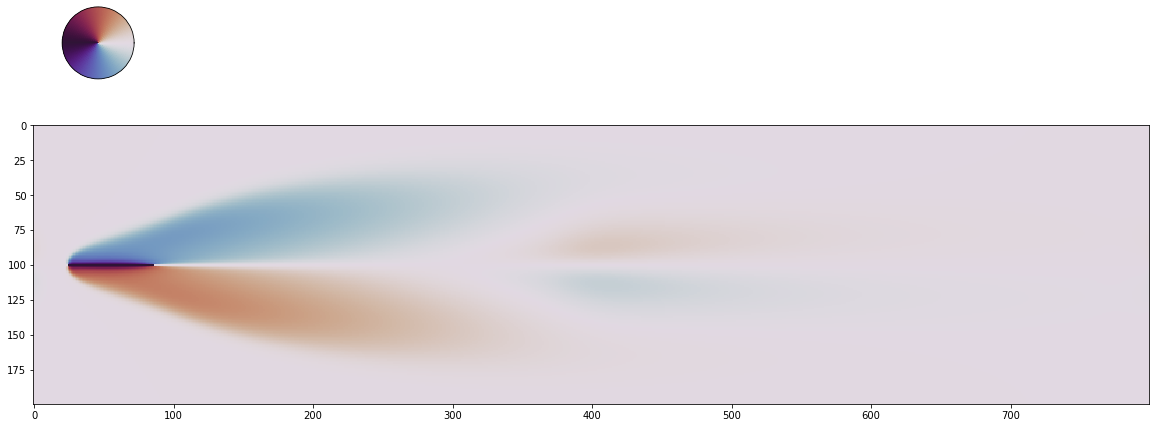

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

azimuths = np.arange(-180, 181, 1)
zeniths = np.arange(0, 20, 1)
values = azimuths * np.ones((20, 361))

ax2 = fig.add_axes([0.12, 0.76, 0.1, 0.1], polar=True,)

ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap='twilight_shifted')
ax2.set_yticks([])
ax2.set_xticks([])

t=3100
mxp=prof_mx[t].copy()
myp=prof_my[t].copy()
ax.imshow(np.arctan2(myp,mxp), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)


# stepx=10
# stepy=40
# norm=np.sqrt(mxp[::stepx, ::stepy]**2+myp[::stepx, ::stepy]**2)
# ax.quiver(x[::stepx, ::stepy],y[::stepx, ::stepy],mxp[::stepx, ::stepy]/norm,myp[::stepx, ::stepy]/norm, scale=80, width=1e-3)

plt.show()

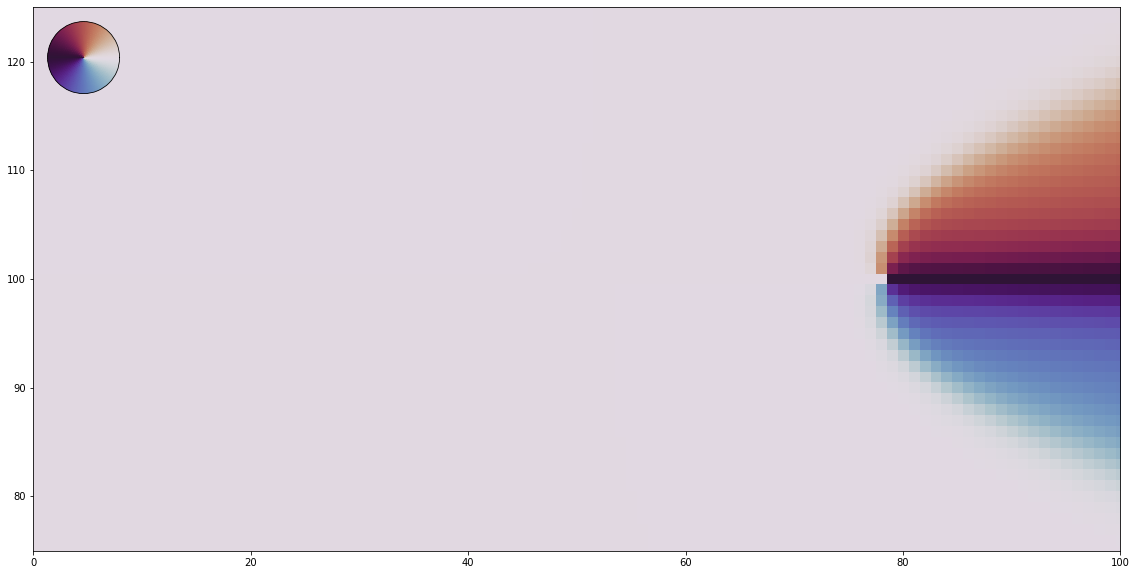

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

azimuths = np.arange(-180, 181, 1)
zeniths = np.arange(0, 20, 1)
values = azimuths * np.ones((20, 361))

ax2 = fig.add_axes([0.12, 0.76, 0.1, 0.1], polar=True,)

ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap='twilight_shifted')
ax2.set_yticks([])
ax2.set_xticks([])

t=2500
mxp=prof_mx[t].copy()
myp=prof_my[t].copy()
ax.imshow(np.arctan2(myp,mxp), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)
ax.set_xlim(0,100)
ax.set_ylim(75,125)

# stepx=10
# stepy=40
# norm=np.sqrt(mxp[::stepx, ::stepy]**2+myp[::stepx, ::stepy]**2)
# ax.quiver(x[::stepx, ::stepy],y[::stepx, ::stepy],mxp[::stepx, ::stepy]/norm,myp[::stepx, ::stepy]/norm, scale=80, width=1e-3)

plt.show()

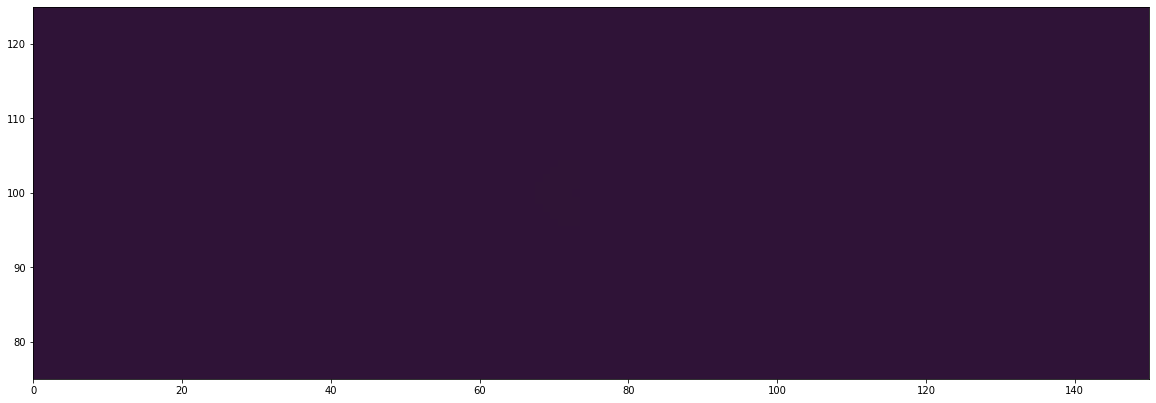

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)



t=2600
mxp=prof_mx[t].copy()
myp=prof_my[t].copy()
im=ax.imshow(prof_rho[t]>5, cmap='twilight_shifted')
ax.set_xlim(0,150)
ax.set_ylim(75,125)
#plt.colorbar(im)
# stepx=10
# stepy=40
# norm=np.sqrt(mxp[::stepx, ::stepy]**2+myp[::stepx, ::stepy]**2)
# ax.quiver(x[::stepx, ::stepy],y[::stepx, ::stepy],mxp[::stepx, ::stepy]/norm,myp[::stepx, ::stepy]/norm, scale=80, width=1e-3)

plt.show()

(75, 125)

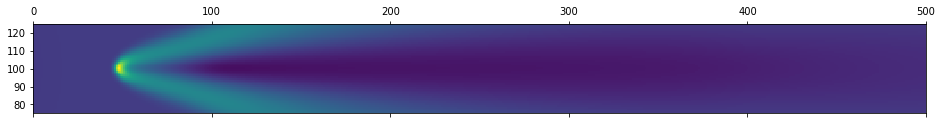

In [96]:
t=2800
plt.matshow(prof_rho[t])
plt.xlim(0,500)
plt.ylim(75,125)

In [84]:
val=[np.sum(prof_rho[t]>5) for t in range(6000)]

(-5, 100)

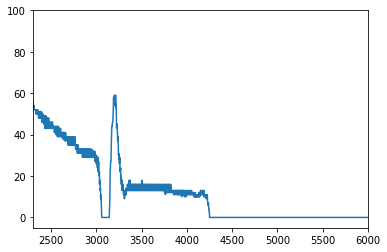

In [93]:
plt.plot(val)
plt.xlim(2300,6000)
plt.ylim(-5,100)

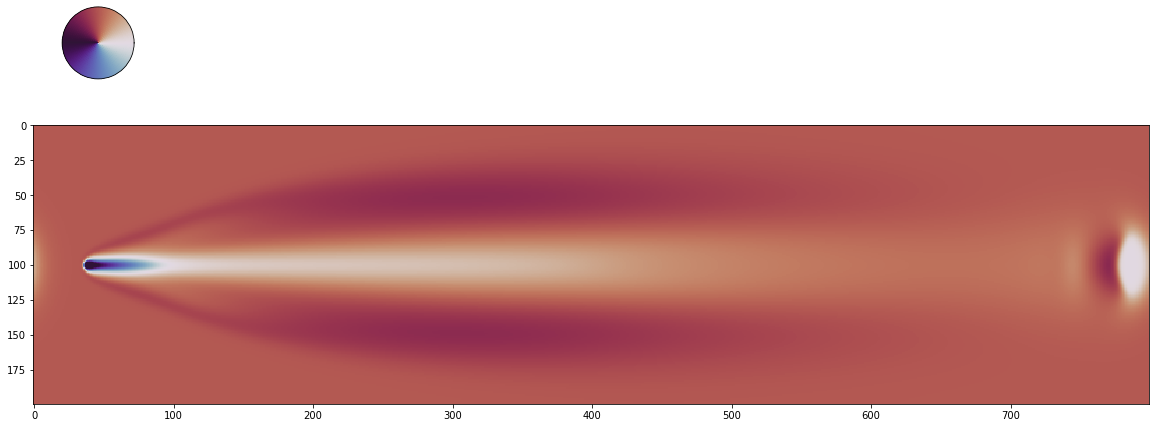

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

azimuths = np.arange(-180, 181, 1)
zeniths = np.arange(0, 20, 1)
values = azimuths * np.ones((20, 361))

ax2 = fig.add_axes([0.12, 0.76, 0.1, 0.1], polar=True,)

ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap='twilight_shifted')
ax2.set_yticks([])
ax2.set_xticks([])

t=2900
ax.imshow(prof_mx[t], cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)


# stepx=10
# stepy=40
# norm=np.sqrt(mxp[::stepx, ::stepy]**2+myp[::stepx, ::stepy]**2)
# ax.quiver(x[::stepx, ::stepy],y[::stepx, ::stepy],mxp[::stepx, ::stepy]/norm,myp[::stepx, ::stepy]/norm, scale=80, width=1e-3)

plt.show()

(0, 100)

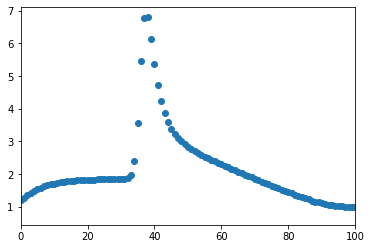

In [40]:
plt.plot(prof_rho[t][100,:], 'o')
plt.xlim(0,100)

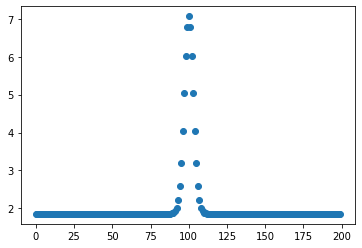

In [58]:
plt.plot(prof_rho[t][:,80], 'o')


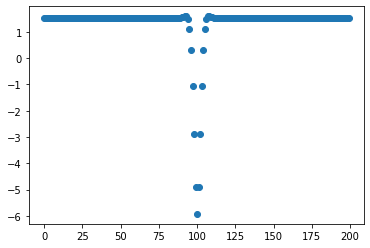

In [59]:
plt.plot(prof_mx[t][:,80], 'o')


# Movies

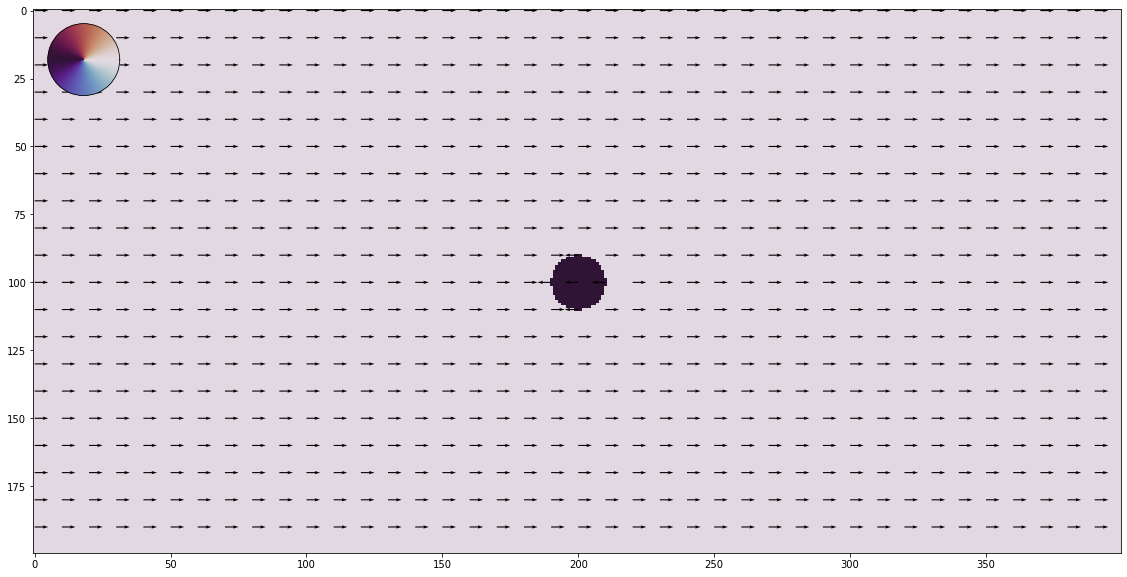

In [140]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

azimuths = np.arange(-180, 181, 1)
zeniths = np.arange(0, 20, 1)
values = azimuths * np.ones((20, 361))

ax2 = fig.add_axes([0.12, 0.76, 0.1, 0.1], polar=True,)

ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap='twilight_shifted')
ax2.set_yticks([])
ax2.set_xticks([])

frame=0

mxp=prof_mx[frame].copy()
myp=prof_my[frame].copy()
img=ax.imshow(np.arctan2(myp,mxp), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)


norm=np.sqrt(mxp[::stepx, ::stepy]**2+myp[::stepx, ::stepy]**2)
quiv=ax.quiver(x[::stepx, ::stepy],y[::stepx, ::stepy],mxp[::stepx, ::stepy]/norm,myp[::stepx, ::stepy]/norm, scale=80, width=1e-3)

plt.show()

def update(*args):
    global frame
    #print(frame)

    mxp=prof_mx[frame]
    myp=prof_my[frame]
    
    img.set_array(np.arctan2(myp,mxp))
    
    norm=np.sqrt(mxp[::stepx, ::stepy]**2+myp[::stepx, ::stepy]**2)
    quiv.set_UVC(mxp[::stepx, ::stepy]/norm,myp[::stepx, ::stepy]/norm)
    
    frame += 11

    return img,

ani = animation.FuncAnimation(fig, update, 1000)
writer = animation.FFMpegWriter(fps=20)
ani.save('destab_alpha%.1f_h%.1f_v%.1f_beta%.1f_D%.1f.avi'%(alpha, h0, v, beta, D), writer=writer) 